In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

## Load the dataset

In [31]:
# load data
df = pd.read_csv('data/breast_cancer.csv')

In [32]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Prepare the data

In [34]:
# Convert 'diagnosis' to binary for easy plotting and analysis (e.g., Malignant as 1 and Benign as 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

##### Set Index

In [35]:
df.set_index("id", inplace=True)

##### Data Quality

In [36]:
# check for missing or null values

missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


We can see in this dataset no missing values

In [37]:
# Checking for duplicate rows

print("\nNumber of Duplicate Rows:", df.duplicated().sum())


Number of Duplicate Rows: 0


## Exploratory data Analysis

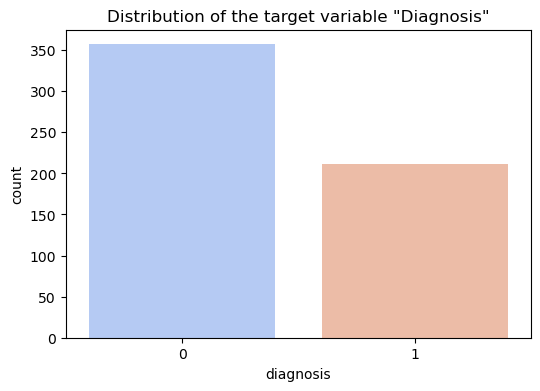

In [38]:
# 1. Distribution of the target variable 'Churn'
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='diagnosis', palette='coolwarm')
plt.title('Distribution of the target variable "Diagnosis"')
plt.show()

Target variable "Diagnosis" appears to be somewhat imbalanced, this could influence metrics and model bias. Thats why we need to consider techniques like class weighting, sampling methods (e.g., SMOTE or undersampling), or evaluation metrics that account for class imbalance.

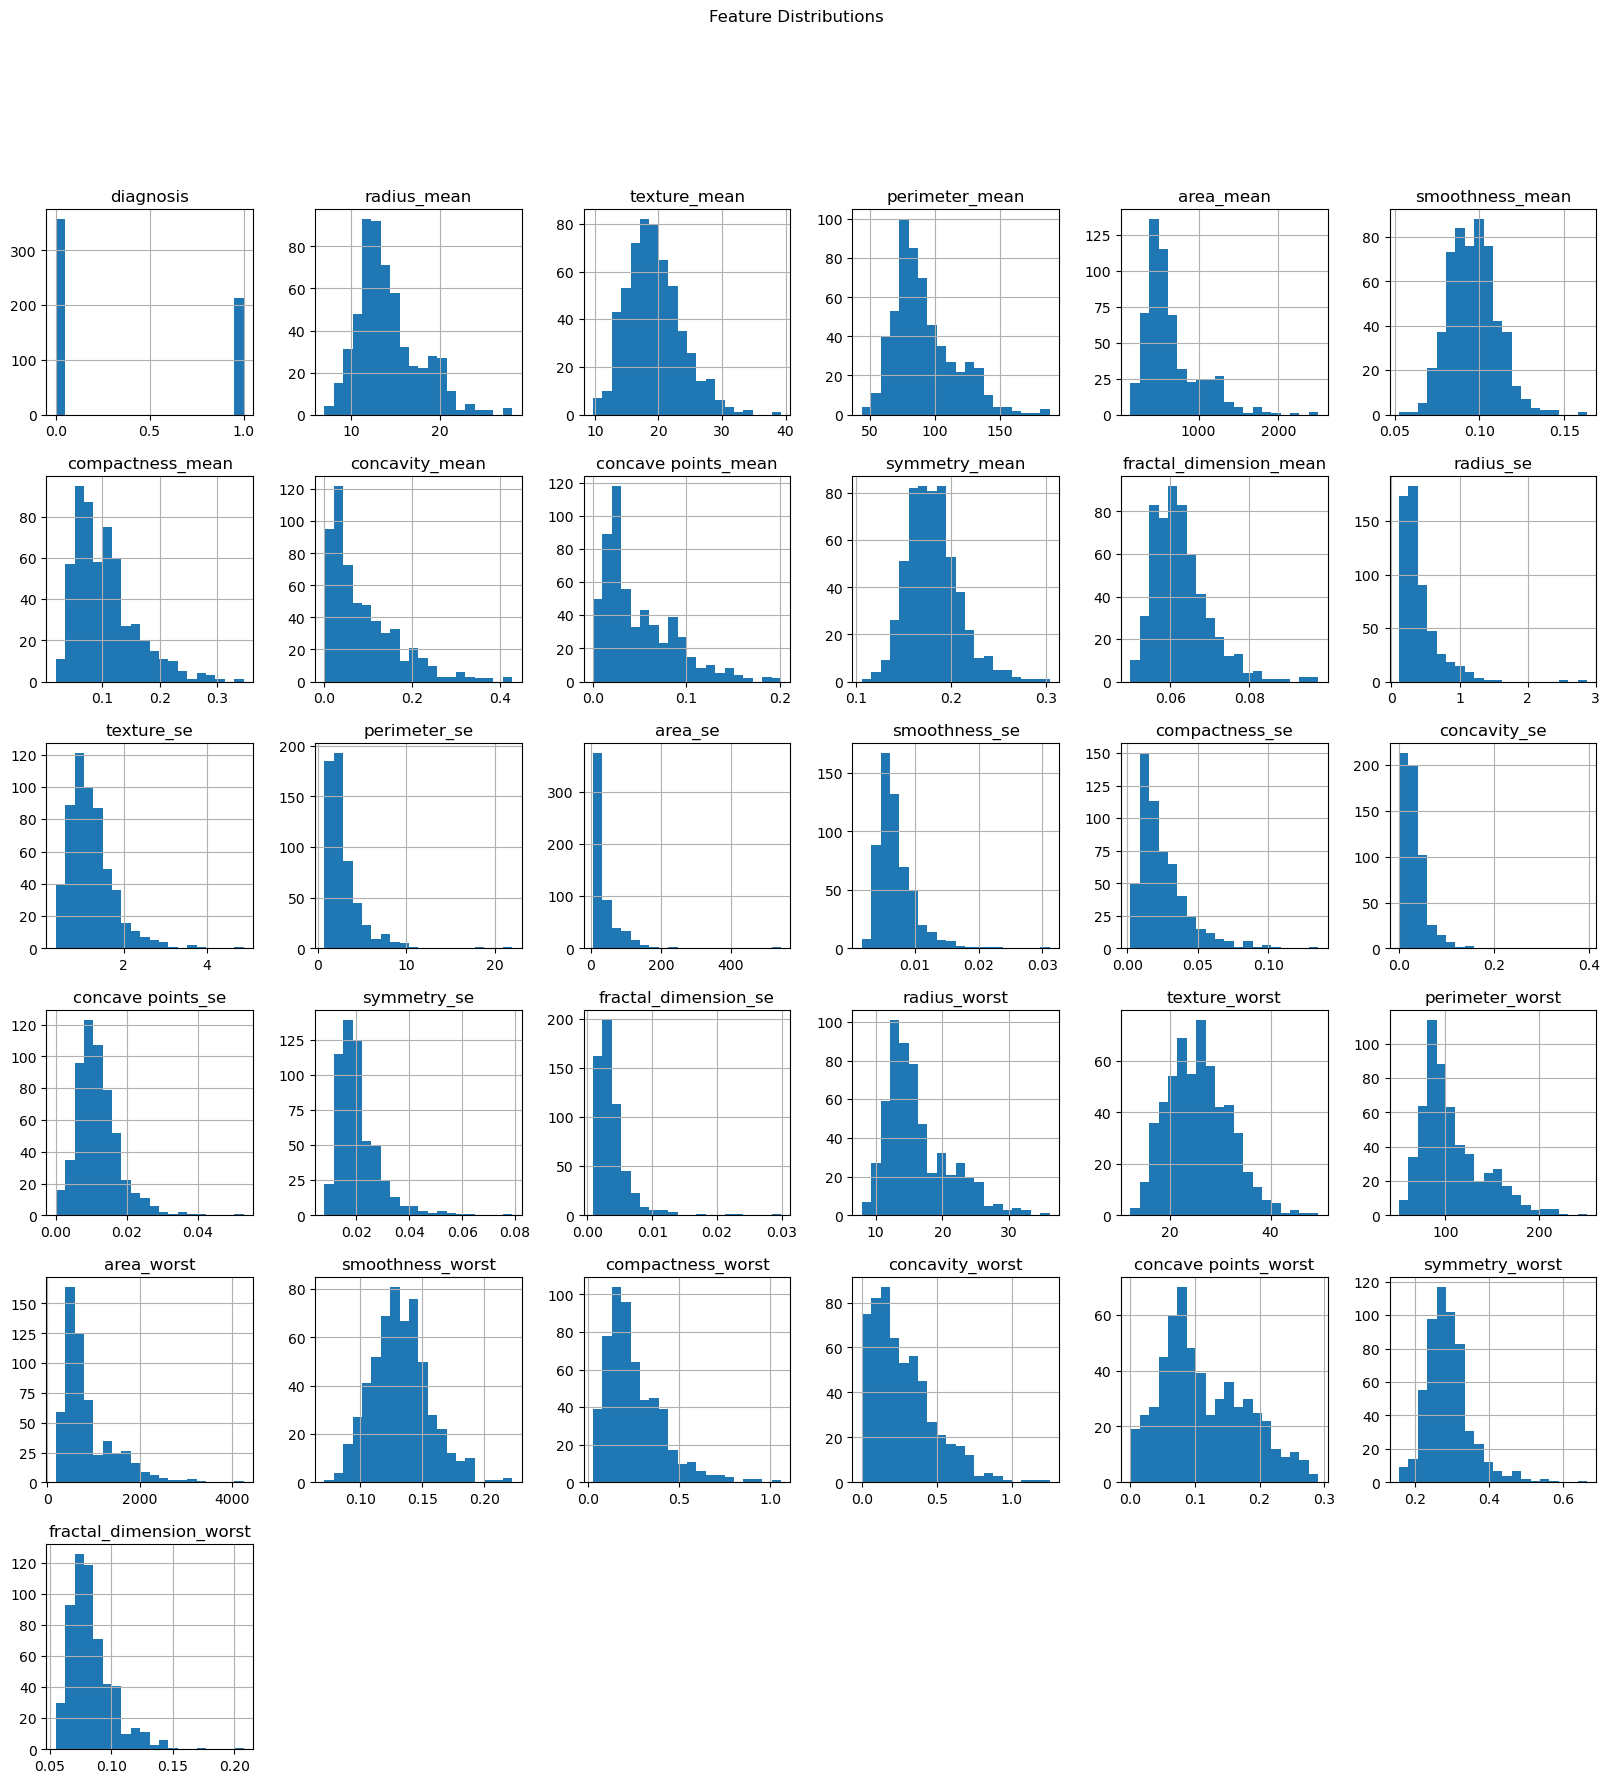

In [39]:
# Step 5: Feature Distributions
# Plot histograms for all features to visualize distribution
df.hist(bins=20, figsize=(20, 20))
plt.suptitle('Feature Distributions')
plt.show()

Each subsequent histogram corresponds to a different feature of the tumor. These features include:
- Mean values of cell nucleus properties (e.g., radius_mean, texture_mean, etc.).
- Worst values (i.e., the maximum values found) of these properties (e.g., radius_worst, texture_worst).
- Standard error (SE) values, representing variability (e.g., radius_se, texture_se).

1. Skewed Distributions: Features like radius_mean, perimeter_mean, and area_mean show right-skewed distributions, indicating that most tumors have smaller values for these metrics, with a few outliers having much larger values.
2. Compactness, Concavity, and Concave Points: These features (e.g., compactness_mean, concavity_mean) show more pronounced skewness towards lower values, suggesting that tumors often have low compactness and concavity.
3. Symmetry and Smoothness: These features (e.g., symmetry_mean, smoothness_mean) show a distribution with a tighter range, suggesting less variability among the tumors.


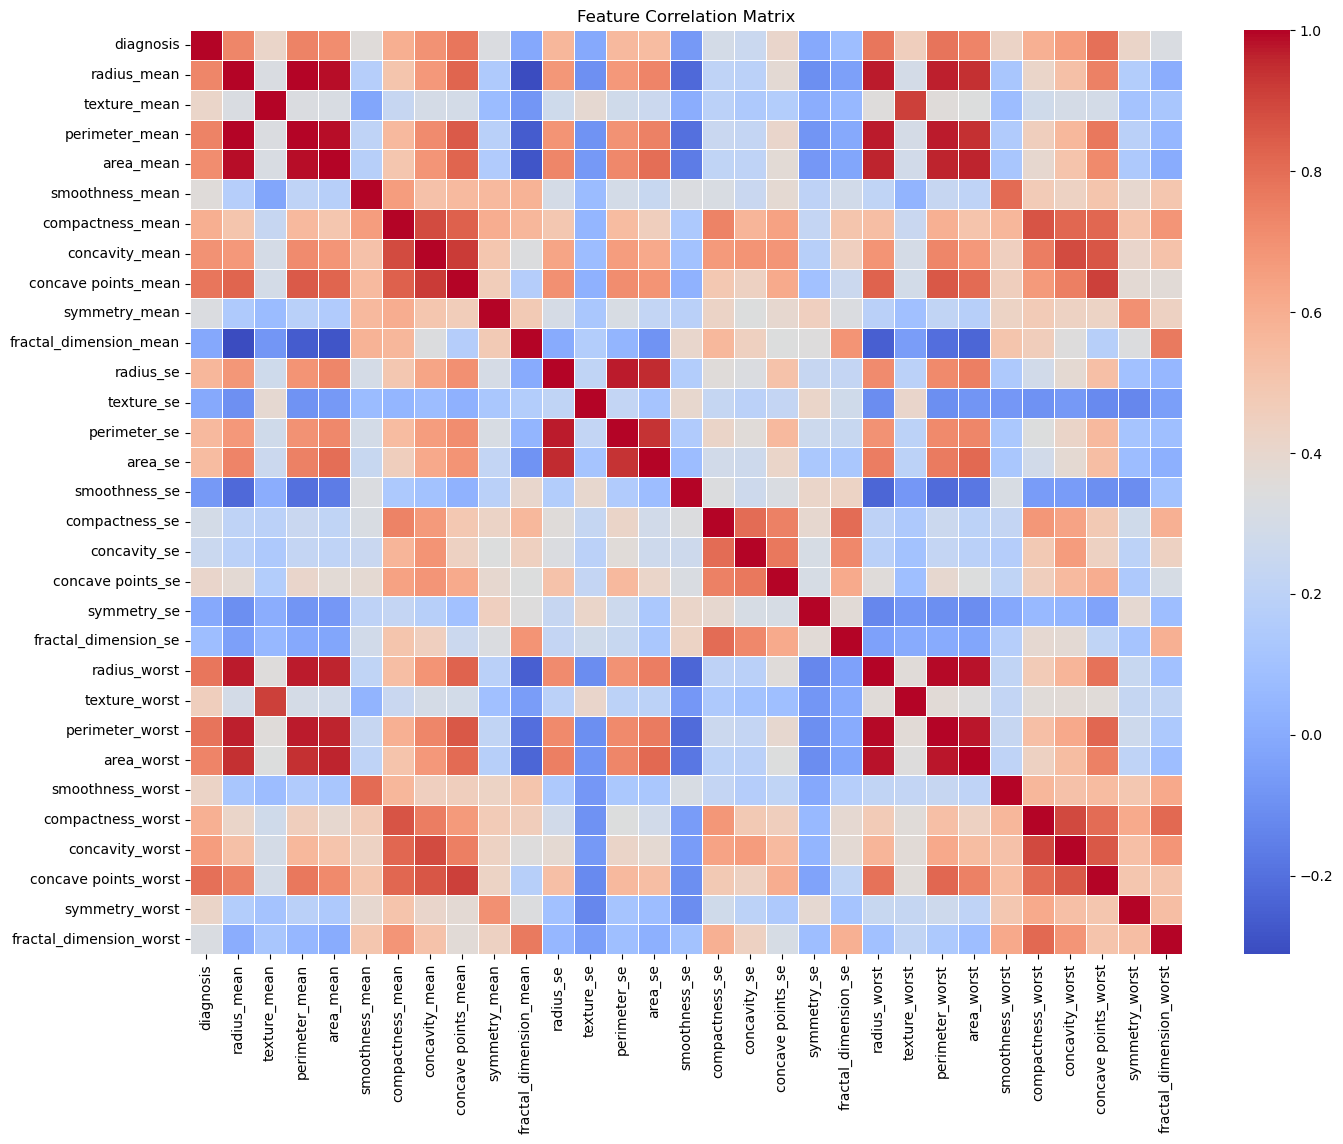

In [40]:
# Step 6: Correlation Analysis
# Compute correlation matrix and visualize with heatmap
corr_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

Key Observations
1. Highly Correlated Features:
For example, radius_mean, perimeter_mean, area_mean, radius_worst, area_worst and perimeter_worst show strong positive correlations with each other. This suggests that these features are measuring similar aspects of the tumors, such as their size or extent.
concave points_mean, concavity_mean and compactness_mean are also highly correlated with concavity_worst and compactness_worst, this suggests that tumors with higher mean values for concave points and concavity tend to also show higher values for these features in their "worst" (i.e., most severe) measurements. Essentially, tumors with more concave points are likely to have a higher degree of concavity and compactness.

2. Implications of Correlated Features:
- Redundancy: Highly correlated features can introduce redundancy in the dataset, which may affect model performance. For example, using both radius_mean and perimeter_mean might not provide additional information since they are capturing similar characteristics.

- Dimensionality Reduction: Techniques like Principal Component Analysis (PCA) or feature selection could be employed to reduce the feature set by focusing on the most informative ones, or we could drop those features that are highly correlated with each other.

3. Final aproach,
We decided not to take any additional measures regarding the highly correlated features for the following reasons:

- Gradient Boosting Classifier (GBC) is a tree-based model, which is inherently robust to multicollinearity (high correlation between features). Unlike linear models, decision trees are not negatively impacted by correlated variables since they split based on the most informative features, even if they overlap. Highly correlated features might still capture unique nuances from different angles (e.g., radius_mean, perimeter_mean, area_mean)




Top Correlated Features with Diagnosis:
 diagnosis               1.000000
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
Name: diagnosis, dtype: float64


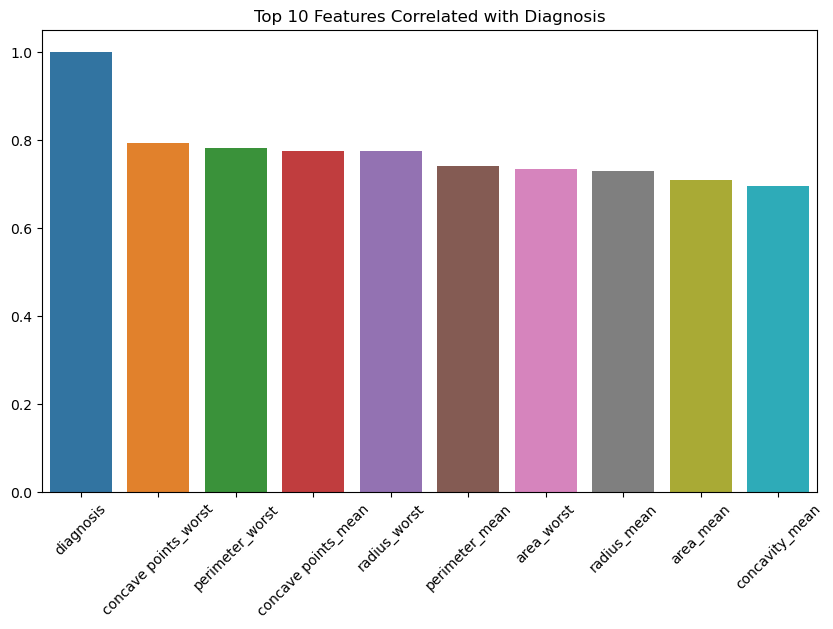

In [41]:
# Optional: Focus on correlations with the target variable ('diagnosis')
# Sort correlations and visualize top correlations with 'diagnosis'
target_corr = corr_matrix['diagnosis'].sort_values(ascending=False)
print("\nTop Correlated Features with Diagnosis:\n", target_corr.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index[:10], y=target_corr.values[:10])
plt.title('Top 10 Features Correlated with Diagnosis')
plt.xticks(rotation=45)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

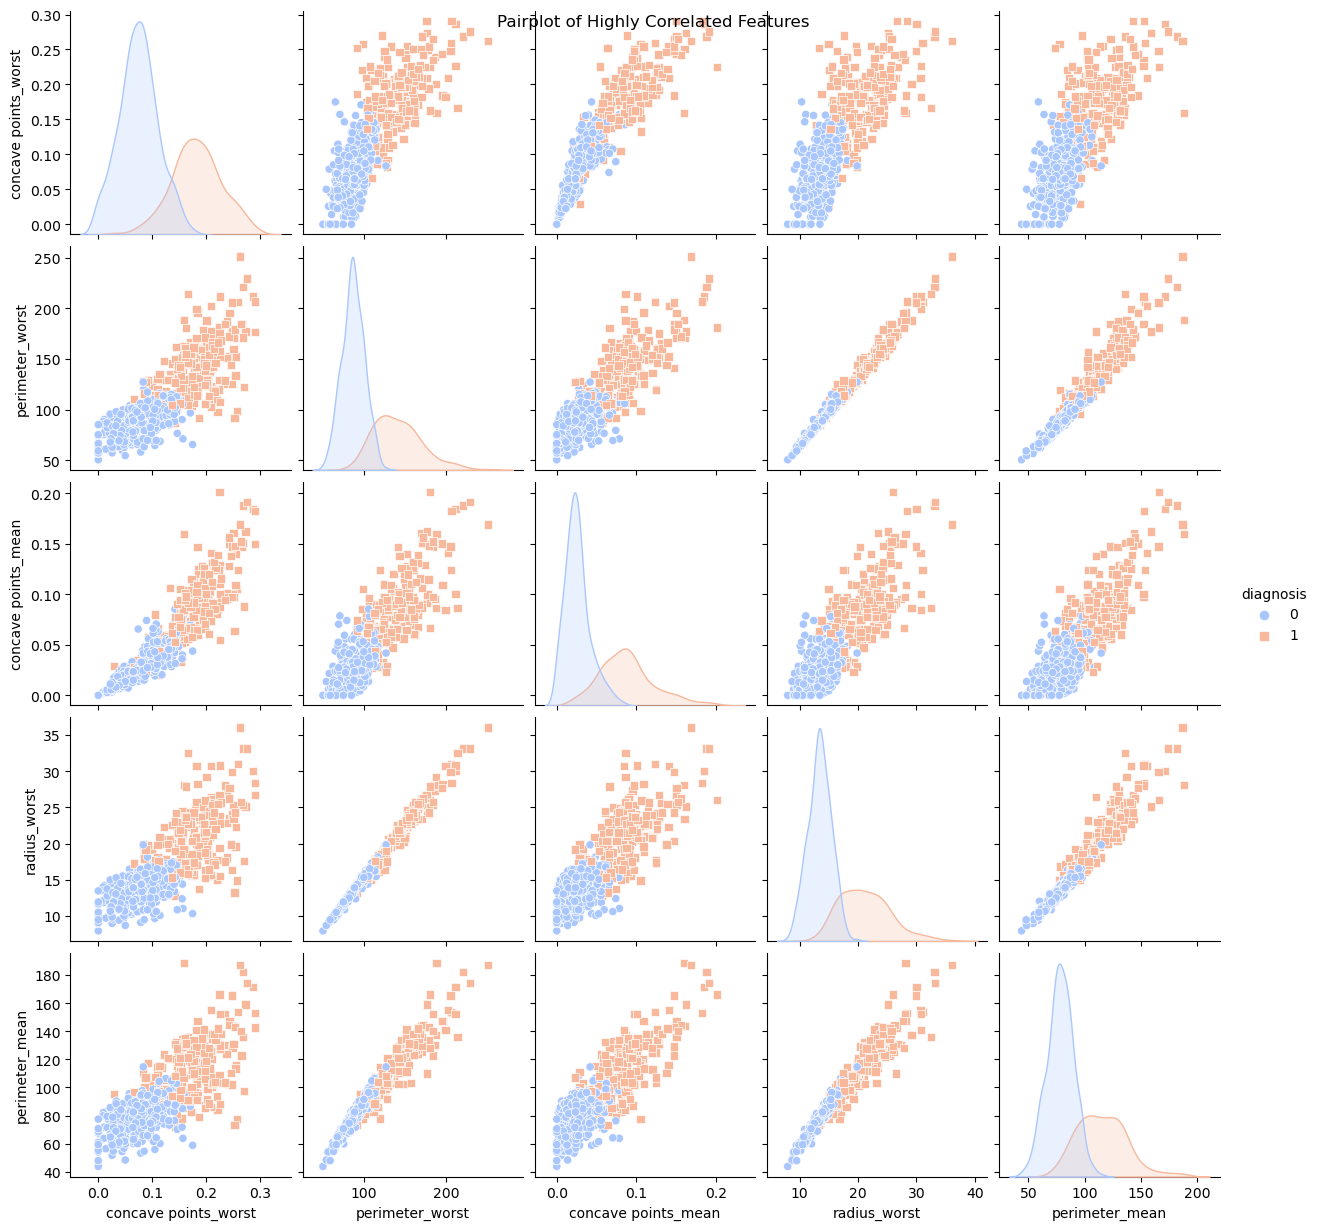

In [42]:
# Step 7: Pairplot of Highly Correlated Features
# Visualize relationship between top features correlated with 'diagnosis'
top_features = target_corr.index[1:6]  # Excluding 'diagnosis' itself
sns.pairplot(df, vars=top_features, hue='diagnosis', palette='coolwarm', markers=["o", "s"])
plt.suptitle('Pairplot of Highly Correlated Features')
plt.show()

- Concave Points (Worst & Mean):

**concave points_worst** (0.79) and **concave points_mean** (0.78) have the highest correlation with the diagnosis.
This suggests that tumors with a higher number of concave points (indentations on the tumor's surface) are strongly associated with being malignant. These features are among the most indicative of malignancy.

- Perimeter (Worst & Mean):

**perimeter_worst** (0.78) and **perimeter_mean** (0.74) are also highly correlated with a malignant diagnosis.
Larger perimeters indicate bigger and more irregular tumor shapes, which are characteristic of malignant tumors.

- Radius (Worst & Mean):

**radius_worst** (0.78) and **radius_mean** (0.73) show a strong correlation as well.
A larger tumor radius tends to be indicative of malignancy, as cancerous tumors are often larger in size compared to benign ones.

- Area (Worst & Mean):

**area_worst** (0.73) and **area_mean**(0.71) also have a strong positive correlation.
Tumor area is another indicator of size, and larger areas are more commonly seen in malignant tumors.

- Concavity (Mean):

**concavity_mean** (0.70) is another feature with a strong correlation to malignancy.
This indicates that tumors with a more concave shape are more likely to be cancerous.


These high correlation values suggest that features like concave points, perimeter, radius, and area are highly informative in predicting whether a tumor is malignant or benign.
Given their strong correlation with the target, the Gradient Boosting Classifier will likely leverage these features heavily during its learning process to improve prediction accuracy.

In [43]:
# Set a correlation threshold (typically above 0.8 or 0.85 indicates high correlation)
correlation_threshold = 0.8

# Compute correlation matrix
corr_matrix = df.corr().abs()

# Identify features with high correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

print("Features with high correlation (to consider for elimination):", high_corr_features)


Features with high correlation (to consider for elimination): ['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'concavity_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'fractal_dimension_worst']


Because I am planning to use a Gradient Boosting Classifier, you generally don't need to drop highly correlated features. Tree-based models, including Gradient Boosting, are less sensitive to multicollinearity because they split based on the most informative features, effectively handling redundancy during the model-building process.

## Build a Model

In [44]:
# Split the dataset into features (X) and target (y)
X = df.drop(columns='diagnosis')
y = df['diagnosis']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing

##### Encode categorical variables

We are not able to perform OneHotEncoding as there is not categorical values in our dataset

##### Handling class imbalance

In [45]:
# Handling class imbalance using SMOTE 
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

##### Scaling all features

In general, Gradient Boosting algorithms, including GradientBoostingClassifier, are not sensitive to feature scaling or standardization. Unlike models such as logistic regression or K-nearest neighbors, tree-based algorithms (like decision trees, random forests, and gradient boosting) split data based on the order of feature values rather than their absolute scales.

However, there are still situations where scaling can be beneficial:

1. Improved Convergence: Scaling can slightly improve training speed for some implementations, especially if the data has large variance across features.

In [46]:
# Standardize the data 
sc = StandardScaler()
X_train_final = sc.fit_transform(X_train_resampled)
X_test_final = sc.transform(X_test)  

# Create a DataFrame from the standardized data
X_train_final = pd.DataFrame(X_train_final, columns=X_train_resampled.columns, index=X_train_resampled.index)
X_test_final = pd.DataFrame(X_test_final, columns=X_test.columns, index=X_test.index)

### Model Training

We chose the Gradient Boosting Classifier for the breast cancer classification problem because:

- High Accuracy: It’s a powerful model that often outperforms simpler algorithms, which is essential in a medical setting where accuracy is critical.

- Captures Complex Patterns: Gradient Boosting can learn intricate relationships between features, improving prediction for data with non-linear patterns, like those in breast cancer features.

- Handles Imbalanced Data: It’s robust with imbalanced datasets, focusing more on difficult cases, which helps improve recall for the minority class (malignant cases).

- Feature Importance Insights: It provides feature importance scores, helping identify key predictive features, which is valuable for interpretability in healthcare.

In [47]:
# Initialize the GradientBoosting model
gb = GradientBoostingClassifier()

# Define parameter grid for hyperparameter optimization
param_grid = {"n_estimators":[1,5,10,20,40,100],'max_depth':[3,4,5,6]}

# Use RandomizedSearchCV for hyperparameter optimization
search_gb = RandomizedSearchCV(
    estimator=gb, 
    param_distributions=param_grid, 
    n_iter=20, 
    cv=6, 
    n_jobs=-1, 
    verbose=1, 
    scoring='roc_auc'
)

# Fit the model
search_gb.fit(X_train_final, y_train_resampled)

Fitting 6 folds for each of 20 candidates, totalling 120 fits


RandomizedSearchCV(cv=6, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [1, 5, 10, 20, 40,
                                                         100]},
                   scoring='roc_auc', verbose=1)

### Model Evaluation

In [49]:
# Evaluate the model on the training and test set
train_hard_output_gb = search_gb.predict(X_train_final)
test_hard_output_gb = search_gb.predict(X_test_final)

# Calculate metrics for GradientBoosting model
precision_train_gb = precision_score(y_train_resampled, train_hard_output_gb)
recall_train_gb = recall_score(y_train_resampled, train_hard_output_gb)
f1_train_gb = f1_score(y_train_resampled, train_hard_output_gb)
roc_auc_train_gb = roc_auc_score(y_train_resampled, search_gb.predict_proba(X_train_final)[:, 1])

precision_test_gb = precision_score(y_test, test_hard_output_gb)
recall_test_gb = recall_score(y_test, test_hard_output_gb)
f1_test_gb = f1_score(y_test, test_hard_output_gb)
roc_auc_test_gb = roc_auc_score(y_test, search_gb.predict_proba(X_test_final)[:, 1])

# Print the evaluation metrics
print(f'GradientBoosting train metrics: Precision={precision_train_gb} - Recall={recall_train_gb} - F1={f1_train_gb} - ROC AUC={roc_auc_train_gb}')
print(f'GradientBoosting test metrics: Precision={precision_test_gb} - Recall={recall_test_gb} - F1={f1_test_gb} - ROC AUC={roc_auc_test_gb}')

GradientBoosting train metrics: Precision=1.0 - Recall=1.0 - F1=1.0 - ROC AUC=1.0
GradientBoosting test metrics: Precision=1.0 - Recall=0.9534883720930233 - F1=0.9761904761904763 - ROC AUC=0.998689813298395


The model demonstrates excellent performance on both the training and test datasets, with particularly strong precision and ROC AUC scores.
The slight drop in recall on the test set indicates that the model missed a few positive cases but still performed exceptionally well overall.
The perfect training metrics suggest a risk of overfitting, as the model might be too complex and tailored to the training data. However, given the strong test metrics, especially the near-perfect ROC AUC, the model appears to generalize well to new data.


### Some useful Charts for Classification

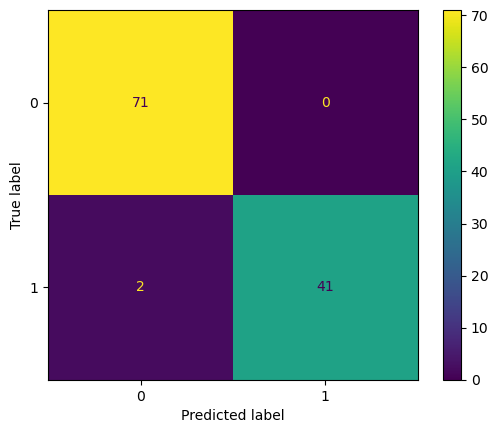

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, test_hard_output_gb)


In this matrix, the two classes are represented as "0" and "1," where:

- Class 0 (labeled "0" in the matrix): Likely represents benign cases.
- Class 1 (labeled "1" in the matrix): Likely represents malignant cases.
Here's a breakdown of the confusion matrix values:

1. True Positives (Bottom-right, 41): The model correctly identified 41 malignant cases as malignant.
2. True Negatives (Top-left, 71): The model correctly identified 71 benign cases as benign.
3. False Positives (Top-right, 0): The model did not incorrectly classify any benign cases as malignant (perfect in this regard).
4. False Negatives (Bottom-left, 2): The model incorrectly classified 2 malignant cases as benign.

The model is highly accurate, with excellent precision and recall for both benign and malignant cases. The model has no false positives, meaning it does not incorrectly flag benign cases as malignant. However, it does have a small number of false negatives, where it incorrectly classifies some malignant cases as benign. This could be significant for a healthcare application, as missing malignant cases may have serious implications.

In [51]:
from sklearn import metrics
import plotly.express as px

# Get the predicted probabilities for the positive class (1)
fpr, tpr, _ = metrics.roc_curve(y_test, search_gb.predict_proba(X_test_final)[:,1])

# Plot the ROC curve using plotly
fig = px.line(x=fpr, y=tpr, title='ROC Curve for Gradient Boosting', labels={'x': 'False Positive Rate', 'y': 'True Positive Rate'}, template="none")
fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random Classifier')
fig.show()

In [54]:
best_model = search_gb.best_estimator_

# Get feature importances from the best model
importances = best_model.feature_importances_
feature_names = X.columns

# Sort features by importance
feature_importances = sorted(zip(importances, feature_names), reverse=True)

# Display top 10 most important features
top_features = feature_importances[:10]
print("Top 10 Important Features:")
for importance, name in top_features:
    print(f"{name}: {importance}")

Top 10 Important Features:
concave points_mean: 0.6856527984865661
perimeter_worst: 0.07436024735947888
radius_worst: 0.0713080939933816
texture_worst: 0.056381204006098425
concavity_worst: 0.02141736552386345
texture_mean: 0.015640535951991278
texture_se: 0.010000610706941047
concave points_worst: 0.009445640333257696
fractal_dimension_se: 0.008901190994535345
area_worst: 0.008375899830348572


1. concave points_mean (Importance: 0.6857)
This feature has the highest importance score, indicating it is the most influential predictor in the model. It represents the mean number of concave points on the contour of the tumor, which suggests how "indented" or "concave" the tumor shape is. Malignant tumors tend to have more irregular shapes with more concave points, which makes this feature a strong indicator of malignancy.

2. perimeter_worst (Importance: 0.0744)
This feature represents the largest (worst) perimeter measurement of the tumor cells. Malignant tumors typically have a larger perimeter due to their irregular shape and rapid growth, so a higher perimeter can indicate malignancy.

3. radius_worst (Importance: 0.0713)
This is the worst (largest) radius of the tumor cells. Malignant tumors often have a larger radius because they tend to grow more aggressively and exhibit larger cell structures. This feature helps the model identify potentially malignant growths based on size.

4. texture_worst (Importance: 0.0564)
This feature measures the variation in texture (or gray-scale variation) within the tumor cells. Malignant tumors usually have more heterogeneous texture, which might indicate more disorganized cell structures, making this an important feature for distinguishing malignant cells.

5. concavity_worst (Importance: 0.0214)
This feature represents the largest concavity measurement of the tumor contours. Concavity reflects the "indentation" or inward curving of the tumor’s perimeter, which is more prominent in malignant tumors. A higher concavity measurement can indicate irregular cell shapes associated with malignancy.

6. texture_mean (Importance: 0.0156)
This is the average texture variation in the tumor cells. Like texture_worst, a higher mean texture value may indicate more disorganized, varied structures within the cells, which can be associated with malignancy.

7. texture_se (Importance: 0.0100)
The standard error of texture measures the variation in texture across samples. High variation could suggest inconsistent cell structures, which is often a characteristic of malignant tumors.

8. concave points_worst (Importance: 0.0094)
This is the worst (highest) value for the number of concave points on the tumor perimeter. Like concave points_mean, a higher value of concave points can indicate a more irregular shape, which is often associated with malignancy.

9. fractal_dimension_se (Importance: 0.0089)
The standard error of fractal dimension represents the variability in the "roughness" of the tumor contour. Malignant tumors tend to have more irregular boundaries, so higher variability in fractal dimension can signal malignancy.

10. area_worst (Importance: 0.0084)
This feature represents the largest measured area of the tumor cells. Malignant tumors are typically larger, and the model uses this feature to help detect tumors with abnormal growth patterns.

- Conclusion:
The most important features for predicting breast cancer malignancy focus on the tumor’s shape (concave points and concavity), size (perimeter, radius, area), and texture (texture_mean and texture_worst). The feature concave points_mean is by far the most influential, suggesting that the shape and irregularity of the tumor contour play a critical role in distinguishing between benign and malignant cases in this model.

In [55]:
import pickle

# Save the best model to a .pkl file
with open("best_gradient_boosting_model.pkl", "wb") as file:
    pickle.dump(search_gb, file)

print("Model saved as best_gradient_boosting_model.pkl")


Model saved as best_gradient_boosting_model.pkl


In [57]:
# Save the scaler for future use
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(sc, scaler_file)